In [21]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm, TwoMaterialFilm
from design import BaseDesign
from spectrum import BaseSpectrum, Spectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_reflection_design, make_three_line_filter_design
from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle

In [2]:
# design = make_edgefilter_design()
# design = make_reflection_design(wls=np.linspace(695, 939, 500))
reps = 10
gts = np.linspace(1000, 10000, 10)
n_size = 2000
n_min = 1.5
n_max = 3

# adam optimizer parameters
alpha = 0.1
batch_size = 200

def exp(n_size, total_gt, design):
    np.random.seed()
    init_n = np.random.random(n_size) * 3 + 1
    init_film = FreeFormFilm(init_n, total_gt, substrate='SiO2')

    adam_optimizer = AdamFreeFormOptimizer(
        init_film, 
        design.target_specs, 
        max_steps=1000, 
        alpha=alpha, 
        record=True, 
        show=False, 
        n_min=n_min, 
        n_max=n_max,
        wl_batch_size=batch_size
    )

    films, losses = adam_optimizer.optimize()
    return films, losses, copy.deepcopy(init_film)

def scan_gts(wl_min, wl_max):
    design = make_reflection_design(wls=np.linspace(wl_min, wl_max, 500))


    films_rep, losses_rep, best_film_rep = [], [], []
    for rep in range(reps):
        films_rep.append([])
        losses_rep.append([])
        best_film_rep.append([])
        for gt in gts:
            films, losses, best_film = exp(n_size, gt, design)
            films_rep[-1].append(films)
            losses_rep[-1].append(losses)
            best_film_rep[-1].append(best_film)
    return films_rep, losses_rep, best_film_rep, design


dependence on hyperparams

In [80]:
def arr_to_fill(ax, x, arr, rep_axis=0, label=''):
    mean = arr.mean(axis=rep_axis)
    std = arr.std(axis=rep_axis)

    ax.plot(x, mean, label=label,)
    ax.fill_between(x, mean - std, mean + std, label='label'+' err bar (1 sigma)', alpha=0.4)

def plot_rep_violin(ax, x, arr, label):
    arr_ls = [arr[:, i] for i in range(arr.shape[1])]
    s = ax.violinplot(
        arr_ls, 
        x, 
        widths=500
    )
    return mpatches.Patch(
        color=s['bodies'][0].get_facecolor().flatten(), 
        label=label
    )

def show_scan_gts(gts, best_film_rep, design, fig=None, ax=None, label=''):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1)
    best_loss_rep = [[
            np.log10(calculate_RMS_f_spec(
                best_film, 
                design.target_specs, 
            )) for best_film in best_film_ls] 
        for best_film_ls in best_film_rep]
    best_loss_rep = np.array(best_loss_rep)

    handle = plot_rep_violin(ax, gts, best_loss_rep, label=label+f': {design.target_specs[0].WLS[0]: .0f} to {design.target_specs[0].WLS[-1]: .0f} nm')

    return fig, ax, handle


def make_bragg_losses(gts, wl_min, wl_max, N=7):
    # use two concated Bragg back-reflectors
    # determine central wl

    wl_mids = []
    for i in range(N + 1):
        right_to_wl_min = (i + 1 / 2) / N * (wl_max - wl_min)
        wl_mid = wl_min - 100 + right_to_wl_min
        wl_mids.append(wl_mid)

    wls = np.linspace(wl_min, wl_max, 500)
    target = Spectrum(0., wls, np.ones(wls.shape))
    losses = []

    d_n_mins = [wl_mid / 4 / n_min for wl_mid in wl_mids]
    d_n_maxs = [wl_mid / 4 / n_max for wl_mid in wl_mids]
    
    for gt in gts:
        d = np.array([])
        for i in range(N):
            cur_d = np.array([d_n_mins[i], d_n_maxs[i + 1]])
            rep = int(gt / N // cur_d.sum())
            d = np.append(d, np.tile(cur_d, rep))

        d = np.append(d, gt - d.sum())
        film = TwoMaterialFilm(n_min, n_max, 'SiO2', d)

        losses.append(np.log10(calculate_RMS_f_spec(film, [target])))

    return losses

In [ ]:

wl_min_and_wl_max = zip([600, 550, 400], [800, 1200, 1500])
for wl_min, wl_max in wl_min_and_wl_max:
    films_rep, losses_rep, best_film_rep, design = scan_gts(wl_min, wl_max)
    save(f'./raw_result/reflector_minwl_{wl_min}_maxwl_{wl_max}_batch_size_{batch_size}_alpha_{alpha}_n_min{n_min}_n_max{n_max}', losses_rep, best_film_rep, design)
    

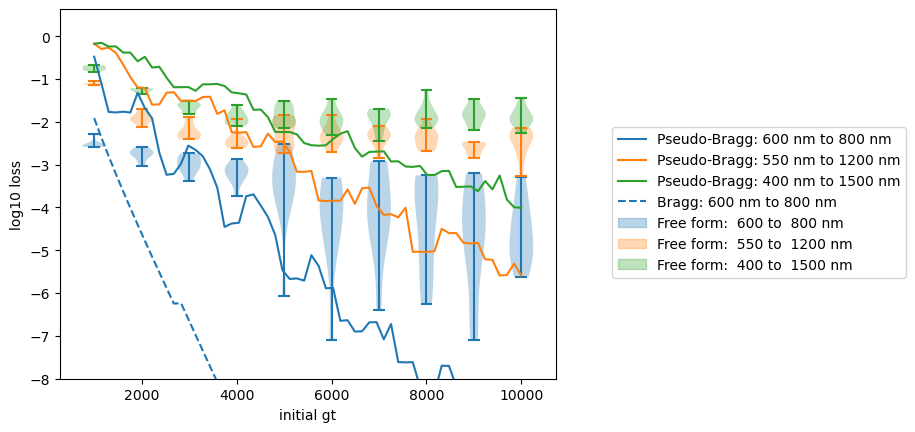

In [90]:
fig, ax = plt.subplots(1, 1)
wl_mins = [600, 550, 400]
wl_maxs = [800, 1200, 1500]

violin_handles = []
for wl_min, wl_max in zip(wl_mins, wl_maxs):
    losses_rep, best_film_rep, design = load(f'./raw_result/reflector_minwl_{wl_min}_maxwl_{wl_max}_batch_size_{batch_size}_alpha_{alpha}_n_min{n_min}_n_max{n_max}')
    _, _, handle = show_scan_gts(gts, best_film_rep, design, fig, ax, label='Free form')
    violin_handles.append(handle)

# Bragg
gts_dense = np.linspace(1000, 10000, 60) # ~ 1 min
for wl_idx, (wl_min, wl_max) in enumerate(zip(wl_mins, wl_maxs)):
    bragg_losses = make_bragg_losses(gts_dense, wl_min, wl_max, N=7)
    ax.plot(gts_dense, bragg_losses, label=f'Pseudo-Bragg: {wl_min} nm to {wl_max} nm', c=f'C{wl_idx}')

bragg_losses = make_bragg_losses(gts_dense, wl_mins[0], wl_maxs[0], N=1)
ax.plot(gts_dense, bragg_losses, label=f'Bragg: {wl_mins[0]} nm to {wl_maxs[0]} nm', c=f'C0', ls='--')

    

all_handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=all_handles+violin_handles, bbox_to_anchor=(1.1, 0.7))
ax.set_xlabel('initial gt')
ax.set_ylabel('log10 loss')
ax.set_ylim(-8, None)

fig.savefig('./results/design/target_range_and_OT_cmp_Bragg.png', dpi=300, bbox_inches='tight')

In [93]:
losses_rep, best_film_rep, design = load(f'./raw_result/reflector_minwl_600_maxwl_800_batch_size_200_alpha_0.1_n_min1.5_n_max3')


0.002585344395377933
film has no spec. use 1000 nm


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.0028632482894620946
film has no spec. use 1000 nm
0.0027201394983908753
film has no spec. use 1000 nm
0.002725090638331024
film has no spec. use 1000 nm
0.005305262317690023
film has no spec. use 1000 nm
0.00267004115708168
film has no spec. use 1000 nm
0.002865106354617177
film has no spec. use 1000 nm
0.0031352089590244883
film has no spec. use 1000 nm
0.0026220457004210987
film has no spec. use 1000 nm
0.002782246978952052
film has no spec. use 1000 nm


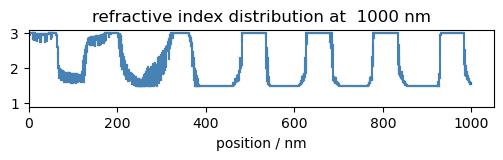

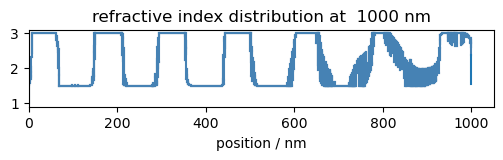

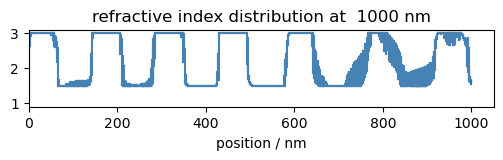

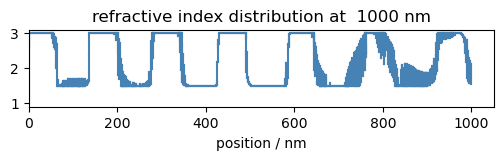

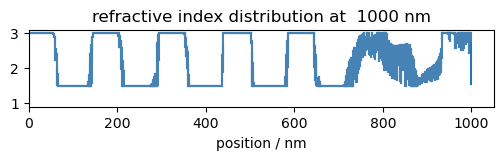

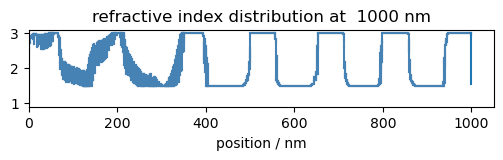

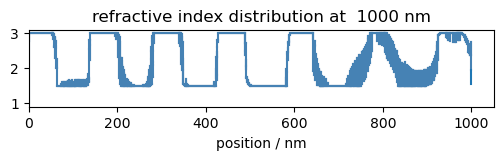

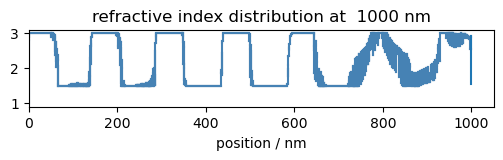

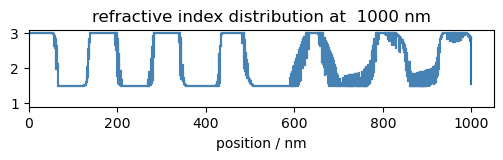

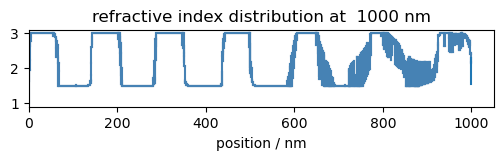

In [98]:
for rep in range(10): # they are similar! narrow target and small allowed gt
    # rep = 2
    gt_idx = 0

    # fig, ax = plt.subplots(1, 1)
    # for gt, losses in zip(gts, losses_rep[rep]):
    #     ax.plot(losses, label=f'{gt}')
    # ax.legend()
    # ax.set_yscale('log')

    print(calculate_RMS_f_spec(
        best_film_rep[rep][gt_idx], 
        design.target_specs
    )) # well I think this is when the grad explodes... using smaller grad

    plot_layer_thickness(best_film_rep[rep][gt_idx])

8

save & load result

In [40]:
from analyze_utils.result_io import save, load
save('back_reflector_result', films_rep, losses_rep, best_film_rep)
# films_rep, losses_rep = load('tmp')


plot film structure

film has no spec. use 700 nm


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


film has no spec. use 1000 nm
film has no spec. use 700 nm
film has no spec. use 1000 nm
film has no spec. use 700 nm
film has no spec. use 1000 nm


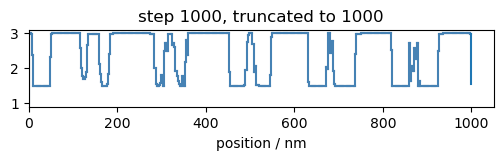

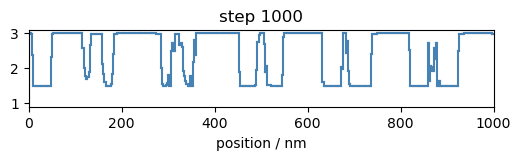

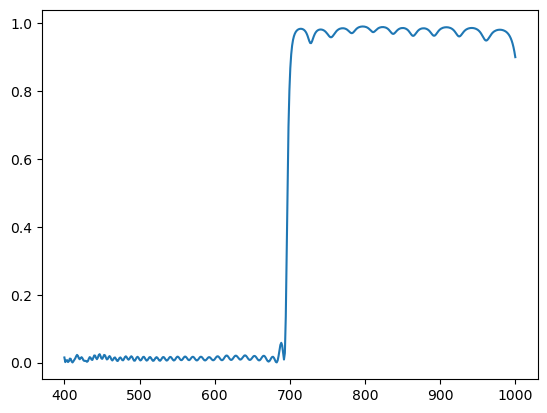

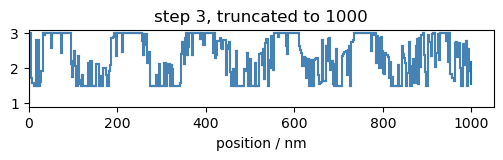

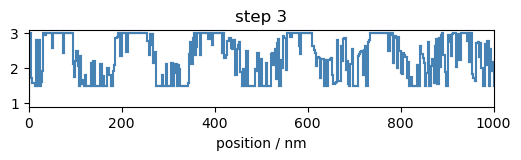

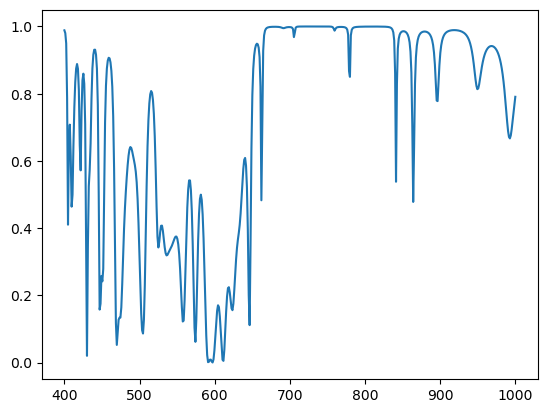

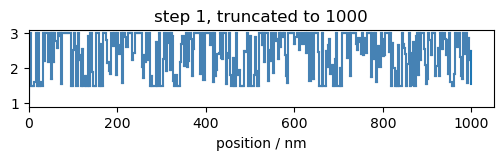

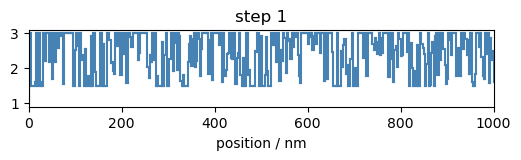

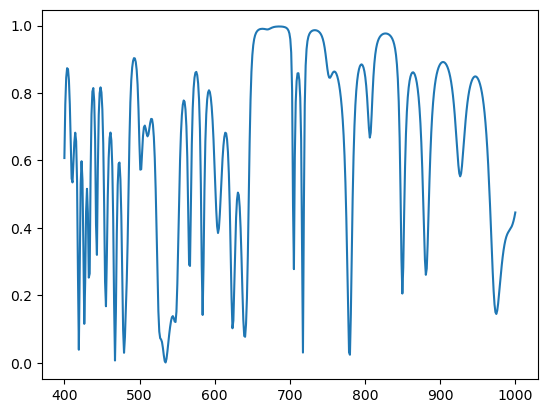

In [36]:
from analyze_utils.structure import plot_layer_thickness

plot_i = [1, 3, -1]
param_id = 10 # OT idx. 0: min; -1: max
rep_id = 0
truncate_thickness = 1000
for i in plot_i[::-1]:
    f: BaseFilm = copy.deepcopy(films_rep[rep_id][param_id][i])

    wl = 700
    ax, fig = plot_layer_thickness(f, n_at_wl=wl, truncate_thickness=truncate_thickness)
    ax.set_title(f'step {i if i >= 0 else len(films_rep[rep_id][param_id]) + i}, truncated to {truncate_thickness}')
    # fig.savefig(fpath + f'step_{i}.png', dpi=300, bbox_inches='tight')

    ax, fig = plot_layer_thickness(films_rep[rep_id][param_id][i])
    ax.set_title(f'step {i if i >= 0 else len(films_rep[rep_id][param_id]) + i}')
    # fig.savefig(fpath + f'all_depth_step_{i}.png', dpi=300, bbox_inches='tight')

    # 0-th iter, not yet have spectrum.
    fig, ax = plt.subplots(1, 1)
    ax.plot(films_rep[rep_id][param_id][i].get_all_spec_list()[0].WLS, films_rep[rep_id][param_id][i].get_all_spec_list()[0].get_R())